# Filter Bitwidth Optimization
## Mathematical Background

The filter coefficients and signal paths of the filter must be quantized. The optimization routine that maximizes the quantization levels so that minimum number of fractional bits are required to represent the coefficients and state register values uses the following optimization strategy seeks to minimize internal bitwidths of the filter architecture by maximizing the quantization levels:

$maximize\; c^{T}\Delta_{q} \left(objective\;function\right)$

$\sqrt{H_{k}}\Delta_{q} \le\sqrt{\gamma_{noise}-\sigma_{nom_{1}}^{2}-\sigma_{nom_{2}}^{2}} \left(quantization\;noise\;bound\right)$

$\left|S^{\tilde{H}_{\Sigma\Delta}^{'}(f_{d})}\left(f_{d}\right)\right|\Delta_{q} \preceq\rho\left(f_{d}\right) \left(sensitivity\;bound\right)$

$\sqrt{12\cdot f_{B}\cdot\sigma_{x\Sigma\Delta}^{2}}\mathtt{\preceq}\Delta_{q} \preceq1 \left(\Delta_{q}\;range\;bound\right)$

where $c=\left[\begin{array}{cccc}1 1 \cdots 1\end{array}\right]$. The objective function of the optimization routine relies on the quantization noise and sensitivity bounds of the filter as well as the value limit imposed by the representation noise floor created by the input and output $\Sigma\Delta$ modulators. There are two performance bounds chosen by the designer in this model:

1. The noise bound $\gamma_{noise}\in\mathbb{R}_{\ge0}$ which sets the upper bound on the resolution of the filter over the specified signal band.

2. The magnitude sensitivity bound $\rho\left(f\right)\in\mathbb{R}^{n}$ which sets an upper bound on the magnitude variation of the filter across the specified signal band.

Steps taken to construct this optimization routine require first that the frequency band of interest (typically from DC to $f_{B}$) be discretized so that a convex optimization solver can solve the problem over a discrete set of points. Creating a discretized vector of frequencies $f_{D}$ will be in the form

$f_{D}=\left[\begin{array}{cccc}f_{0} f_{1} \cdots f_{M}\end{array}\right]$

where $M$ is the number of samples.

Next, $f_{D}$ must be used to create the sensitivity matrix $\left|S^{\tilde{H}_{\Sigma\Delta}^{'}(f_{d})}\left(f_{D}\right)\right|$ for use in the sensitivity bound of the filter. The resulting matrix will be of the form

$\left|S^{\tilde{H}_{\Sigma\Delta}^{'}(f_{d})}\left(f\right)\right|=\left[\begin{array}{cccc}
\left|S_{01}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{0}\right)\right| &\left|S_{02}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{1}\right)\right| &\cdots &\left|S_{0K}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{M}\right)\right|\\
\left|S_{11}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{0}\right)\right| &\left|S_{12}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{1}\right)\right| &\cdots &\left|S_{1K}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{M}\right)\right|\\
\left|S_{21}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{0}\right)\right| &\left|S_{22}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{1}\right)\right| &\cdots &\left|S_{2K}^{\tilde{H}_{\Sigma\Delta}^{'}}\left(f_{M}\right)\right|\\
\vdots &\ddots &\ddots &\vdots\\
\left|S_{N1}\left(f_{0}\right)\right| &\left|S_{N2}\left(f_{1}\right)\right| &\cdots &\left|S_{NK}\left(f_{M}\right)\right|
\end{array}\right]$


Now the performance bounds must be chosen by a designer. For the transfer function sensitivity, $\rho\left(f_{D}\right)$ must be chosen to put an upper bound on the transfer function variation that the filter design would tolerate. The bound vector will be in the vector form of

$\rho\left(f_{D}\right)=\left[\begin{array}{cccc}
\rho\left(f_{0}\right) &\rho\left(f_{1}\right) &\cdots &\rho\left(f_{M}\right)\end{array}\right]$

The last performance bound to chose in the output noise bound of the filter $\gamma_{noise}$. The noise bound puts an upper bound on the maximum tolerable noise level on the output of the filter over the frequency range $f_{D}$. For a required output ENOB of 14 for instance, the bound should be chosen in absolute terms to be $\gamma_{noise}=1e-8$.

[$\Sigma\Delta$ Stream Computation](https://escholarship.org/uc/item/4f46n0h6)

## Choosing Filter Bitwidths

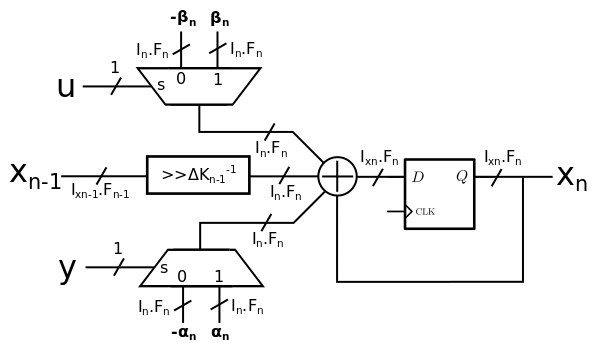

In [1]:
from IPython.display import Image
Image(filename='./Figures/filter_node_bitwidths.png')

When it comes to assigning bitwidths to the interior signal paths of the $\Sigma\Delta$ filter architecture, there are two considerations that must be made: the bitwidths of the coefficients and the bitwidths of the state registers. Since the numerical representation of these values will be in two's compliment form, each value will consist of a bitwidth $B_{w}\in\mathbb{Z}^{+}$ given by

$B=I+F+1$

where $I\in\mathbb{Z^{+}}$ are the integer bits, $F\in\mathbb{Z^{+}}$ are the fractional bits, and a one for the sign bit. For the number of integer bits I that should be assigned to the coefficients at the ith node is

$I_{i}=\left\lceil max\left(log_{2}\left(\beta_{\delta i}\right),log2\left(\alpha_{\delta i}\right)\right)\right\rceil$

where $\left\lceil \cdot\right\rceil$  is the ceiling operator. The number for fractional bits F at the ith node can be determined by

$F_{i}=\begin{cases}\left\lceil \left|log2\left(\Delta_{qi}\right)\right|\right\rceil , & \Delta_{qi}<1\\
0, & otherwise \end{cases}$

In regards to setting the register bitwidths, notice again that the $\alpha$, $\beta$, and previous scaled state variable all share the same summation node. It is appropriate then to set the number of fractional bits of the proceeding integrator register to $F_{i}$. The number of integer bits $I_{xi}$ of the state register can be found by

$I_{xi}=\left\lceil \left|log2\left(\Delta\right)\right|\right\rceil$

leaving the total bitwidth of the ith register

$B_{xi}=I_{xi}+F_{i}+1$

[$\Sigma\Delta$ Stream Computation](https://escholarship.org/uc/item/4f46n0h6)

In [2]:
# %load ./header.py
import numpy as np
from scipy import signal
from scipy import linalg
import control
import matplotlib.pyplot as plt

import sys

if '../sdfpy' not in sys.path:
  sys.path.insert(0,'../sdfpy')

import sd_sim
import sdfpy as sdf

OSR = 256      # oversample ratio
fb = 22050     # nyquist
fs = OSR*2*fb  # sampling frequency
ts = 1/fs      # sampling period


In [3]:
%store -r
[Ad,Bd,Cd,Dd,k,k_inv,T0,Ts,f,ts,alpha,beta] = the_delta_filter
[sig_2_nom, sig_2_x_sd, H] = the_noise
[S_mag, S_phz] = the_sensitivity
# [sig_nom, sig_2_x_sd, h1] = the_noise

In [4]:
SNR = 90
sig_noise = 10**(-(SNR/10))
p = .1*np.ones((1,S_mag.shape[1]))
s = np.sqrt(np.trapz(sig_2_x_sd)*(12*OSR));
S_mag = np.squeeze(S_mag)

In [5]:
import cvxpy as cp
n = S_mag.shape[0]
u = np.ones((n,1))
l = np.zeros((n,1))
f = np.ones(n)
f[0] = 3
s = np.append(s, 0).reshape(s.shape[0] + 1, 1)

# Define and solve the CVXPY problem.
q = cp.Variable((n,1))
prob = cp.Problem( cp.Maximize(f @ q),
                   [ cp.quad_form(q,H) <= sig_noise
                   , S_mag.T @ q <= p.T
                   , q >= s
                   ]
                 )
prob.solve()

8.769171296775074

C:\qaz\projects\delta-control\notebooks\../sdfpy\sdfpy.py:244: RuntimeWarning: divide by zero encountered in log10
  ax1.semilogx(f,20*np.log10(low_m),'g--')


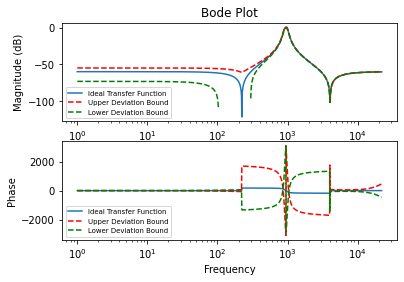

In [6]:
f = np.logspace(0,np.log10(fb),2**10)
sdf.sensitivity_plot(Ad,Bd,Cd,Dd,f,ts,S_mag,S_phz,q.value)

qs = np.log2(q.value)
qs[qs>0] = 0
qs = np.ceil(np.abs(qs)).T
bi = np.ceil(np.log2(np.maximum(np.abs(alpha),np.abs(beta)))) + 1
bw = bi + qs + 1
b_frac = qs

In [7]:
# % Simulink Model Bitwidth Parameters
shift = np.round(np.abs(np.log2(ts*k)))
bw_accum = 1 + np.ceil(np.abs(np.log2(ts))) + b_frac
print('q = \n', np.log2(q.value.T))
print('Coefficient bitwidths = \n', bw)

q = 
 [[-21.07850884  -7.20319832  -7.89947475  -7.51142473   3.12973059]]
Coefficient bitwidths = 
 [[24. 21. 25. 21. 16.]]


In [8]:
k_ts = k * ts
k_ts = np.append(k_ts, 0)
shift = np.append(shift, 1)

for idx, val in enumerate(alpha):
  print('accum[', idx, '] |' , bw_accum[0,idx] , b_frac[0,idx])
  print('alpha[', idx, '] |' , bw[0,idx]       , qs[0,idx]    )
  print('beta [', idx, '] |' , bw[0,idx]       , qs[0,idx]    )
  print('k_ts [', idx, '] |' , shift[idx] + 1  , shift[idx]   )
  print('-' * 40)

accum[ 0 ] | 47.0 22.0
alpha[ 0 ] | 24.0 22.0
beta [ 0 ] | 24.0 22.0
k_ts [ 0 ] | 24.0 23.0
----------------------------------------
accum[ 1 ] | 33.0 8.0
alpha[ 1 ] | 21.0 8.0
beta [ 1 ] | 21.0 8.0
k_ts [ 1 ] | 37.0 36.0
----------------------------------------
accum[ 2 ] | 33.0 8.0
alpha[ 2 ] | 25.0 8.0
beta [ 2 ] | 25.0 8.0
k_ts [ 2 ] | 37.0 36.0
----------------------------------------
accum[ 3 ] | 33.0 8.0
alpha[ 3 ] | 21.0 8.0
beta [ 3 ] | 21.0 8.0
k_ts [ 3 ] | 37.0 36.0
----------------------------------------
accum[ 4 ] | 25.0 0.0
alpha[ 4 ] | 16.0 0.0
beta [ 4 ] | 16.0 0.0
k_ts [ 4 ] | 2.0 1.0
----------------------------------------
